# Event Siting model: Lake County Example


Summary of steps demonstrated below: 

1. Identify census tracts with high housing loss (eviction rate > twice county average)
2. Filter grid cells to select those within 10 mile (15 minute drive time) radius
3. Create cell-level indicators for:
    - Proximity to census tract clusters with high housing loss index scores
        - Plus other housing loss-related indicators suggested by FEAT
    - Proximity to low-income populations
    - Proximity to populations without houshold vehicle access
    - Proximity to non-english-speaking populations
    - AND other constraints suggested by Housd / Bright Community Trust
4. Combine indicators into a cell-level score
5. Rank cells by score and output recommendations

In [1]:
import os
import sys

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely import geometry

rootdir = os.path.abspath("../..")
if rootdir not in sys.path:
    sys.path.append(rootdir)

from src.utils.geo import create_buffer, reaggregate
from src.utils.scoring import standardize, generate_index_score

DATA_DIR = os.path.join("..", "..", "data")

/Users/jtan/opt/anaconda3/envs/housd/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Load Lake county census tract shapefiles

<AxesSubplot:>

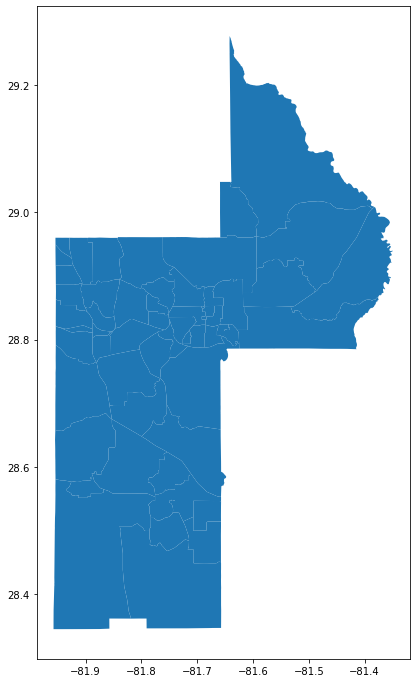

In [2]:
TRACT_PATH = os.path.join(DATA_DIR, "raw", "tl_2017_12_tract")

# Load all florida census tracts
fl_tracts = gpd.read_file(TRACT_PATH).to_crs(4326)

# Lake county FIPS code is 12069
lake_tracts = fl_tracts[fl_tracts['COUNTYFP'] == "069"]
lake_tracts.plot(figsize=(12,12))

### Load existing grid and filter down to Lake County cells only

In [3]:
GRID_PATH = os.path.join(DATA_DIR, "interim", "cleaned_shapefiles", "fl_county_grid.geojson")

county_grids = gpd.read_file(GRID_PATH).to_crs(4326)
lake_grid = gpd.sjoin(county_grids, lake_tracts[['geometry']].dissolve()).drop(columns='index_right')
lake_grid.head()

,cell_id,geometry
0,40,"POLYGON ((-81.95764 28.96279, -81.94866 28.962..."
1,41,"POLYGON ((-81.95764 28.95493, -81.94866 28.954..."
2,42,"POLYGON ((-81.95764 28.94707, -81.94866 28.947..."
3,43,"POLYGON ((-81.95764 28.93921, -81.94866 28.939..."
4,44,"POLYGON ((-81.95764 28.93135, -81.94866 28.931..."


<AxesSubplot:>

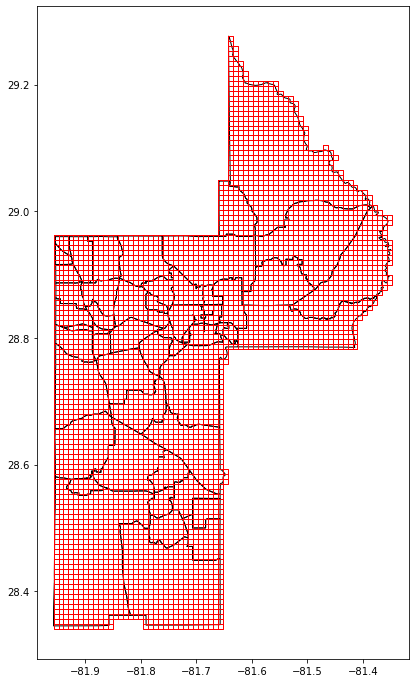

In [4]:
# Plot
fig, ax = plt.subplots(figsize=(12,12))
lake_tracts.plot(ax=ax, color='none')
lake_grid.plot(ax=ax, facecolor='none', edgecolor='r')

### Load FEAT output for Lake County

In [5]:
DATA_PATH = os.path.join(DATA_DIR, "processed", "Lake County FEAT Output", "data_summaries", "housing_loss_summary.csv")

lake_FEAT = pd.read_csv(DATA_PATH)
lake_FEAT.head(3)

,geoid,2019_eviction_filings,2020_eviction_filings,2021_eviction_filings,2022_eviction_filings,total_filings,avg_eviction_filing_rate,nyears_evic_data,2016_mortgage_foreclosures,2017_mortgage_foreclosures,...,pct-renter-occupied,pct-owner-occupied,pct-owner-occupied-mortgage,pct-owner-occupied-without-mortgage,median-house-age,pct-without-health-insurance,pct-non-white,total_housing_loss,total_foreclosures,housing-loss-index
0,12069030302,11,13,11,0,35,0.030810,4,6,6,...,15.392954,84.607046,26.287263,58.319783,36,6.333511,9.5,59,24,0.007995
1,12069030409,7,3,9,1,20,0.038760,4,10,10,...,4.584222,95.415778,33.653163,61.762615,36,3.816631,3.4,67,47,0.005952
2,12069030601,22,19,17,2,60,0.021614,4,9,2,...,34.997479,65.002521,24.054463,40.948058,43,13.293741,25.5,97,37,0.012229


## 1. Identify census tracts with high housing loss (eviction rate > twice county average)

#### Interpreting the average eviction filing rate

Average eviction filing rate is given by:

$$ 
avg\_eviction\_filing\_rate = \frac{total\_filings}{total\_renter\_occupied\_households * nyears\_evic\_data}
$$ 

Source: 
https://www.newamerica.org/future-land-housing/reports/foreclosure-and-eviction-analysis-tool/step-4-interpreting-and-using-feat-outputs

In [6]:
# 2022 is incomplete so we'll have to calculate our own avg_eviction_filing_rate

lake_FEAT['total_filings'] = lake_FEAT[['2019_eviction_filings', '2020_eviction_filings', '2021_eviction_filings']].sum(axis=1)
lake_avg_eviction_filings_rate = lake_FEAT['total_filings'].sum() / (lake_FEAT['total-renter-occupied-households'].sum() * 3)

lake_avg_eviction_filings_rate

0.015558893109913518

In [7]:
# Recalculate housing loss index as ratio of census tract : county average eviction rate
lake_FEAT['annual_evictions_per_hh'] = lake_FEAT['avg_eviction_filing_rate'] / lake_avg_eviction_filings_rate

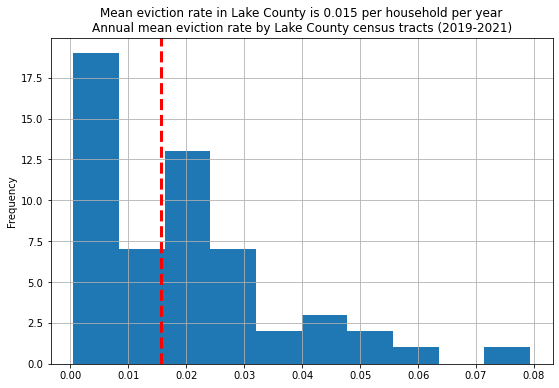

In [8]:
lake_FEAT['avg_eviction_filing_rate'].plot(
    kind="hist",
    title="Mean eviction rate in Lake County is 0.015 per household per year\nAnnual mean eviction rate by Lake County census tracts (2019-2021)",
    grid=True,
    figsize=(9,6)
)

plt.axvline(lake_avg_eviction_filings_rate, color='r', linestyle='--', linewidth=3)

In [9]:
# Merge FEAT values onto shapefile
FEAT_VARS_TO_MERGE = [
    '2019_eviction_filings', '2020_eviction_filings', '2021_eviction_filings', 'avg_eviction_filing_rate',
    'total_housing_loss', 'housing-loss-index', 'annual_evictions_per_hh'
]

lake_FEAT['geoid'] = lake_FEAT['geoid'].astype(str)
lake_df = lake_tracts[['GEOID', 'geometry']] \
    .merge(
        lake_FEAT[['geoid'] + FEAT_VARS_TO_MERGE],
        left_on='GEOID',
        right_on='geoid',
        how='outer'
    )
lake_df.head(3)

,GEOID,geometry,geoid,2019_eviction_filings,2020_eviction_filings,2021_eviction_filings,avg_eviction_filing_rate,total_housing_loss,housing-loss-index,annual_evictions_per_hh
0,12069030307,"POLYGON ((-81.79115 28.84922, -81.79112 28.851...",12069030307,11.0,4.0,5.0,0.013092,50.0,0.006250,0.841465
1,12069030914,"POLYGON ((-81.65239 28.80443, -81.65214 28.805...",12069030914,17.0,14.0,12.0,0.013382,82.0,0.009517,0.860087
2,12069030805,"POLYGON ((-81.80338 28.79003, -81.80245 28.792...",12069030805,18.0,12.0,17.0,0.029012,85.0,0.012220,1.864679


<AxesSubplot:title={'center':'Highest eviction rates are in Leesburg and Fruitland Park\nLake County census tracts by avg annual eviction rate, 2019-2022'}>

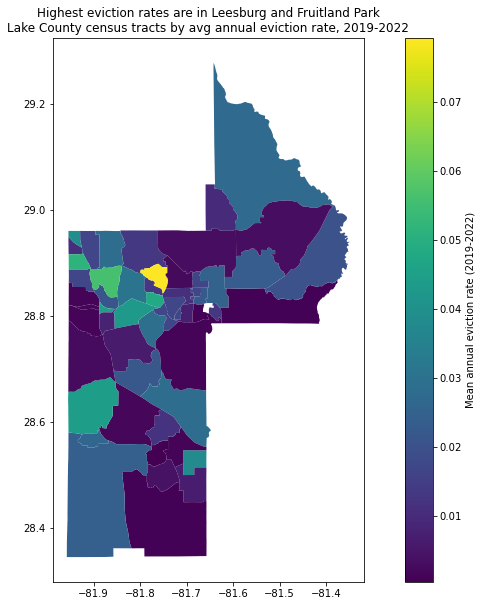

In [10]:
fig, ax = plt.subplots(figsize=(15,10))

ax.set_title("Highest eviction rates are in Leesburg and Fruitland Park\nLake County census tracts by avg annual eviction rate, 2019-2022")
lake_df.plot(
    ax=ax,
    column='avg_eviction_filing_rate', 
    legend=True,
    legend_kwds={
        'label': 'Mean annual eviction rate (2019-2022)'
    }
)

<AxesSubplot:title={'center':'Counties with >2x county average eviction filing rate'}>

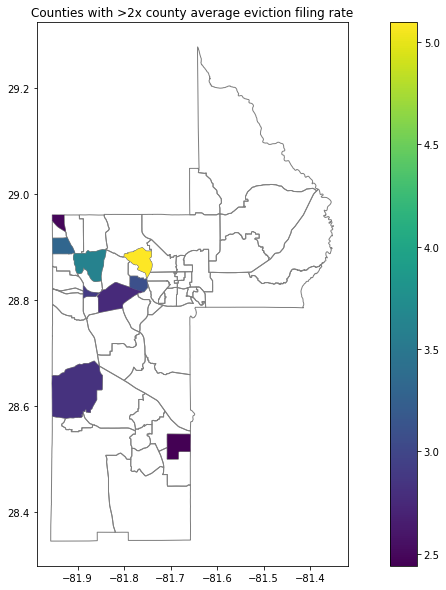

In [11]:
# Plot all census tracts with eviction rate > 2x county average
THRESHOLD_MULTIPLE = 2
lake_eviction_outliers = lake_df[lake_df['annual_evictions_per_hh'] > THRESHOLD_MULTIPLE]

# Plot
fig, ax = plt.subplots(figsize=(15,10))

ax.set_title("Counties with >2x county average eviction filing rate")
lake_df.plot(ax=ax, facecolor='none', edgecolor='gray')
lake_eviction_outliers.plot(ax=ax, column='annual_evictions_per_hh', legend=True)

<AxesSubplot:title={'center':'10 mile (15 min) radius'}>

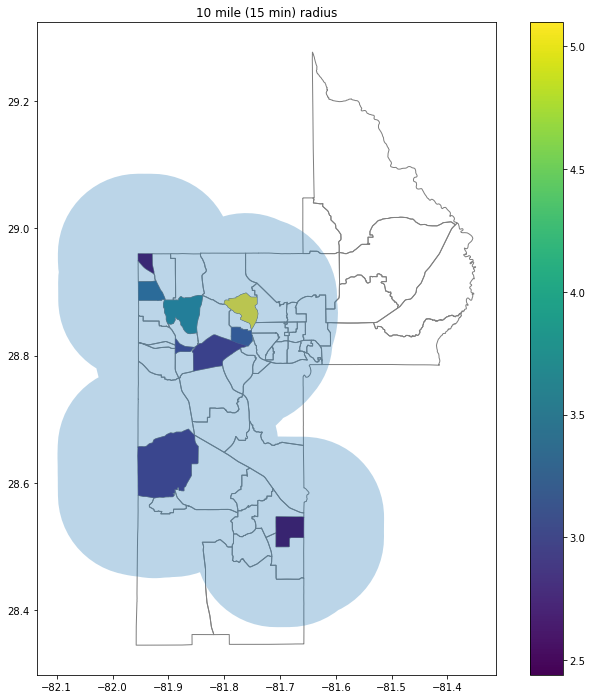

In [12]:
# 15 min driving distance = 10 miles = approx 16 km

# Create buffer 
TEN_MILE_BUFFER_DISTANCE_M = 16 * 1000
buffer_10mile_df = create_buffer(lake_eviction_outliers, size_in_meters = TEN_MILE_BUFFER_DISTANCE_M)

# Plot
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title("10 mile (15 min) radius")
# Plot census tract outlines
lake_df.plot(ax=ax, facecolor='none', edgecolor='gray')
# Plot census tracts with high eviction rates
lake_eviction_outliers.plot(ax=ax, column='annual_evictions_per_hh', legend=True)
# Plot buffers
buffer_10mile_df.plot(ax=ax, alpha=0.3)

## 2. Filter grid cells to select those within 10 mile (15 minute drive time) radius

In [13]:
# Get only grid cells within buffer
lake_grid_in_buffer = gpd.sjoin(
    lake_grid, 
    gpd.GeoDataFrame(buffer_10mile_df, geometry=0),
).drop(columns=["index_right"])

lake_grid_in_buffer

,cell_id,geometry
0,40,"POLYGON ((-81.95764 28.96279, -81.94866 28.962..."
1,41,"POLYGON ((-81.95764 28.95493, -81.94866 28.954..."
2,42,"POLYGON ((-81.95764 28.94707, -81.94866 28.947..."
3,43,"POLYGON ((-81.95764 28.93921, -81.94866 28.939..."
4,44,"POLYGON ((-81.95764 28.93135, -81.94866 28.931..."
...,...,...
3466,8371,"POLYGON ((-81.59831 28.87630, -81.58933 28.876..."
3467,8372,"POLYGON ((-81.59831 28.86844, -81.58933 28.868..."
3468,8373,"POLYGON ((-81.59831 28.86057, -81.58933 28.860..."
3469,8374,"POLYGON ((-81.59831 28.85270, -81.58933 28.852..."


<AxesSubplot:>

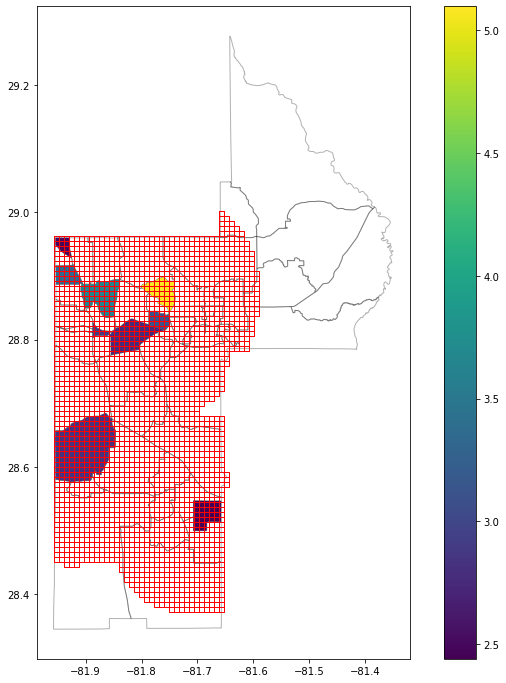

In [14]:
# Plot
fig, ax = plt.subplots(figsize=(12,12))

# Plot census tract outlines
lake_df.plot(ax=ax, color='none', alpha=0.3)
# Plot census tracts with high eviction rates
lake_eviction_outliers.plot(ax=ax, column='annual_evictions_per_hh', legend=True)
# Plot buffer grid cells
lake_grid_in_buffer.plot(ax=ax, facecolor='none', edgecolor='r')

## 3. Merge on POI data for possible event sites

### 3.1 Load previously aggregated Point of Interest data

See the `build-poi-dataset.ipynb` notebook for an example of how we aggregated POI data from various sources.

In [15]:
POI_PATH = os.path.join(DATA_DIR, "interim", "combined_pois.geojson")
poi = gpd.read_file(POI_PATH)

print(poi.shape)
poi.head()

(83614, 5)


,id,name,type,source,geometry
0,95855262,None,camp_site,openstreetmap,POINT (-85.90703 30.23211)
1,96919971,None,memorial,openstreetmap,POINT (-81.66089 30.32608)
2,97557631,Mile 1,tourist_info,openstreetmap,POINT (-85.41047 29.80190)
3,97571939,Hardee Correctional Institution Library,library,openstreetmap,POINT (-82.01485 27.59041)
4,98587924,None,tourist_info,openstreetmap,POINT (-82.96365 29.50284)


In [16]:
# Keep only rows in Lake county
lake_poi = gpd.sjoin(poi, lake_df[['geometry']].dissolve(), how='inner') \
    .drop(columns="index_right")

print(lake_poi.shape)
lake_poi.head()

(1228, 5)


,id,name,type,source,geometry
15,154201254,River Forest Group Site,camp_site,openstreetmap,POINT (-81.39029 29.01269)
139,358691829,Beverly Shores Elementary School,school,openstreetmap,POINT (-81.88258 28.82999)
146,358692338,Bonaire Park,park,openstreetmap,POINT (-81.88675 28.80638)
243,358694513,Dabney Elementary School,school,openstreetmap,POINT (-81.86425 28.80777)
278,358695358,Emmauel Camp,park,openstreetmap,POINT (-81.85730 28.57361)


### 3.2 Filter down to acceptable event location types

In [17]:
# These are the acceptable types of POI to hold events at
ACCEPTABLE_POI_TYPES = [
    'bench',
    'library',
    'town_hall',
    'museum',
    'public_building',
    'community_centre',
    'theatre',
    'stadium',
    'hotel',
    'nonprofit',
    'place_of_worship'
]

In [18]:
# Filter
lake_poi = lake_poi[lake_poi['type'].isin(ACCEPTABLE_POI_TYPES)]

print(lake_poi.shape)

(758, 5)


<AxesSubplot:>

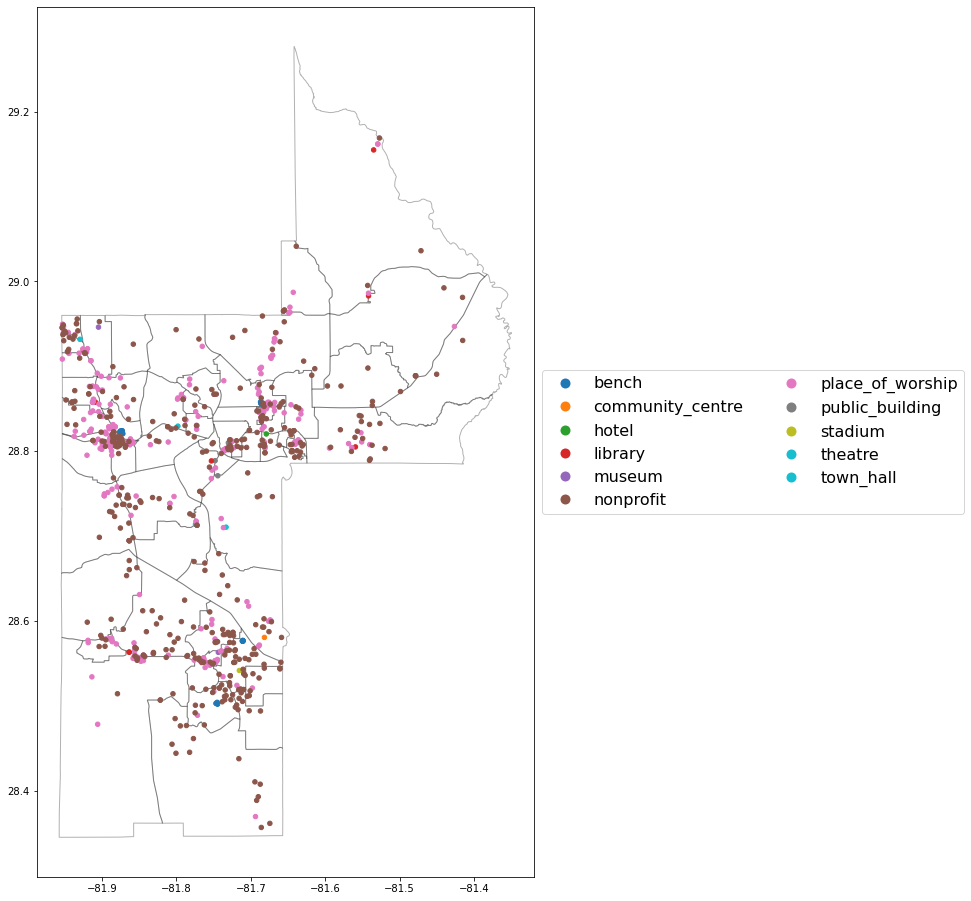

In [19]:
# Plot
fig, ax = plt.subplots(figsize=(16,16))

lake_df.plot(ax=ax, color='none', alpha=0.3)
lake_poi.plot(
    ax=ax, 
    column='type', 
    markersize=20, 
    legend=True,
    legend_kwds={
        'loc': 'center left',
        'bbox_to_anchor': (1, 0.5),
        'ncol': 2,
        'fontsize': 16,
        'markerscale': 1
    }
)

### 3.3 Filter down grid cells to those within buffer containing POI

In [20]:
# Filter grid cells
lake_grid_in_buffer_with_poi = lake_grid_in_buffer.sjoin(lake_poi[['geometry']], how="inner") \
    .drop(columns="index_right") \
    .drop_duplicates()

print(lake_grid_in_buffer_with_poi.shape)
lake_grid_in_buffer_with_poi.head()

(375, 2)


,cell_id,geometry
1,41,"POLYGON ((-81.95764 28.95493, -81.94866 28.954..."
2,42,"POLYGON ((-81.95764 28.94707, -81.94866 28.947..."
3,43,"POLYGON ((-81.95764 28.93921, -81.94866 28.939..."
4,44,"POLYGON ((-81.95764 28.93135, -81.94866 28.931..."
6,46,"POLYGON ((-81.95764 28.91563, -81.94866 28.915..."


In [21]:
# Filter POI 
lake_poi_in_buffer = lake_poi.sjoin(
    gpd.GeoDataFrame(buffer_10mile_df, geometry=0),
    how='inner') \
.drop(columns=['index_right'])

print(lake_poi_in_buffer.shape)
lake_poi_in_buffer.head()

(709, 5)


,id,name,type,source,geometry
3854,358743797,Leesburg High School Stadium,stadium,openstreetmap,POINT (-81.89023 28.80738)
4397,358758585,East Ridge High School Football Stadium,stadium,openstreetmap,POINT (-81.71556 28.54167)
4556,367818857,Lake County School Board,public_building,openstreetmap,POINT (-81.73031 28.80986)
4557,367818860,Lake County Agricultural Center,public_building,openstreetmap,POINT (-81.74806 28.78889)
5852,367823414,Tavares School Media Center,library,openstreetmap,POINT (-81.73611 28.80056)


<AxesSubplot:>

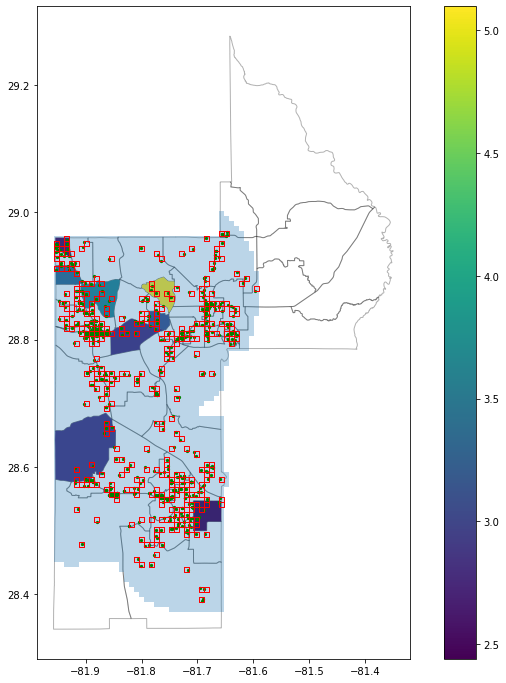

In [22]:
# Plot
fig, ax = plt.subplots(figsize=(12,12))

# Tract outline
lake_df.plot(ax=ax, color='none', alpha=0.3)

# Plot tract value highlights
lake_eviction_outliers.plot(ax=ax, column='annual_evictions_per_hh', legend=True)

# Plot 10 mile radius
lake_grid_in_buffer.dissolve().plot(ax=ax, alpha=0.3)

# Plot POI within 10 mile radius
lake_poi_in_buffer.plot(ax=ax, color='g', markersize=5)

# Plot grid cells containing those POI within buffer
lake_grid_in_buffer_with_poi.plot(ax=ax, facecolor='none', edgecolor='r')

The grid cells above in red (`lake_grid_in_buffer_with_poi`) are those:
- with acceptable POI types 
- within 15 minute driving distance of census tracts with high eviction rates

## 4. Create cell-level demographic indicators

- Start with census tract-level demographic information
- Reaggregate values from census tract to grid cell
- Combine cell-level indicators into an index score for each cell for ranking purposes

### 4.1 Reaggregate tract-level data to cell-level data

In [23]:
# Variables with highest correlation with eviction filings, per lake county FEAT output
lake_FEAT_vars = ['pct-female-single-parent-household', 'mean-commute-time', 'pct-with-snap-benefits', 
                  'pct-below-poverty-level', 'median-household-income']

lake_FEAT.head(3)

,geoid,2019_eviction_filings,2020_eviction_filings,2021_eviction_filings,2022_eviction_filings,total_filings,avg_eviction_filing_rate,nyears_evic_data,2016_mortgage_foreclosures,2017_mortgage_foreclosures,...,pct-owner-occupied,pct-owner-occupied-mortgage,pct-owner-occupied-without-mortgage,median-house-age,pct-without-health-insurance,pct-non-white,total_housing_loss,total_foreclosures,housing-loss-index,annual_evictions_per_hh
0,12069030302,11,13,11,0,35,0.030810,4,6,6,...,84.607046,26.287263,58.319783,36,6.333511,9.5,59,24,0.007995,1.980209
1,12069030409,7,3,9,1,19,0.038760,4,10,10,...,95.415778,33.653163,61.762615,36,3.816631,3.4,67,47,0.005952,2.491160
2,12069030601,22,19,17,2,58,0.021614,4,9,2,...,65.002521,24.054463,40.948058,43,13.293741,25.5,97,37,0.012229,1.389163


In [24]:
# Create geodataframe with demographic vars of interest
lake_tract_indicators = lake_tracts[['GEOID', 'geometry']] \
    .merge(lake_FEAT[['geoid'] + lake_FEAT_vars], how='left', left_on='GEOID', right_on='geoid') \
    .drop(columns=['geoid'])

lake_tract_indicators.head()

,GEOID,geometry,pct-female-single-parent-household,mean-commute-time,pct-with-snap-benefits,pct-below-poverty-level,median-household-income
0,12069030307,"POLYGON ((-81.79115 28.84922, -81.79112 28.851...",1.0,27.3,6.2,5.6,41776.0
1,12069030914,"POLYGON ((-81.65239 28.80443, -81.65214 28.805...",2.9,23.9,13.4,14.3,45481.0
2,12069030805,"POLYGON ((-81.80338 28.79003, -81.80245 28.792...",10.0,26.9,15.4,12.1,48368.0
3,12069030411,"POLYGON ((-81.92915 28.96000, -81.92743 28.960...",2.6,23.3,11.8,14.0,41494.0
4,12069030503,"POLYGON ((-81.95363 28.82076, -81.95326 28.820...",9.9,19.5,29.0,23.9,34716.0


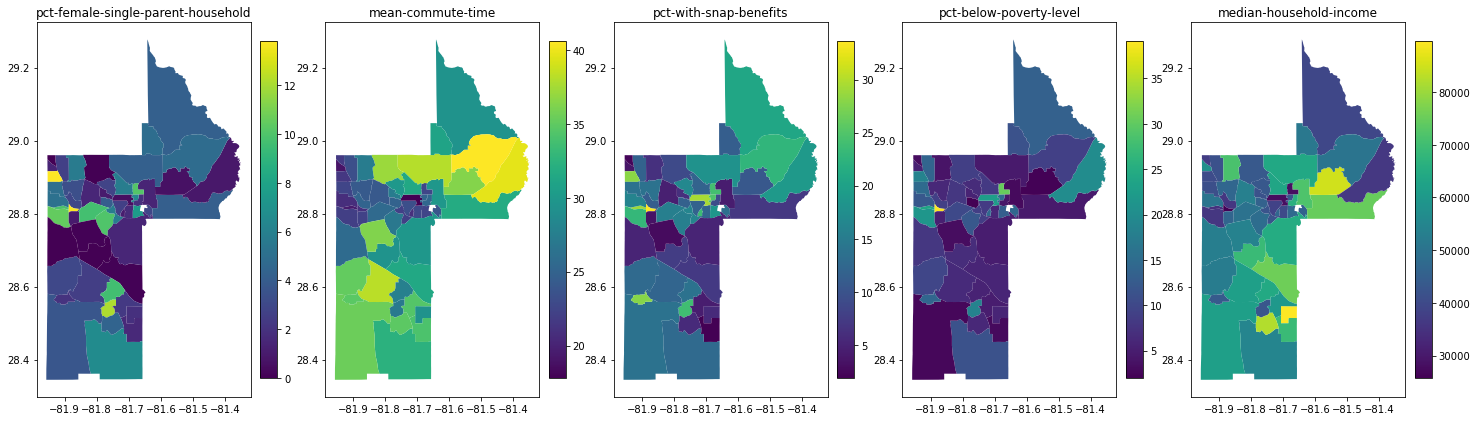

In [25]:
# Plot results so far
num_vars = len(lake_FEAT_vars)
width = 5 * num_vars
fig, ax = plt.subplots(nrows=1, ncols=num_vars, figsize=(width,8))

for idx, i in enumerate(lake_FEAT_vars):
    ax[idx].set_title(i)
    lake_tract_indicators.plot(
        ax=ax[idx],
        column=i,
        legend=True,
        legend_kwds={'fraction': 0.07, 'pad': 0.04}
    )
    
# Eustis, near the center, has high SNAP benefit %, below-poverty-level % and single female parent %
# Fruitland Park in the northwest has high single female parent %, moderate snap benefit %, but low % below poverty

In [26]:
indicators_by_cell = reaggregate(lake_tract_indicators, lake_grid, "cell_id", lake_FEAT_vars)
indicators_by_cell.head()

,cell_id,geometry,pct-female-single-parent-household,mean-commute-time,pct-with-snap-benefits,pct-below-poverty-level,median-household-income
0,40,"POLYGON ((-81.95764 28.96279, -81.94866 28.962...",0.000000,8.688959,0.920950,1.321362,14854.116428
1,41,"POLYGON ((-81.95764 28.95493, -81.94866 28.954...",0.044398,13.144954,1.446718,2.078621,23272.467672
2,42,"POLYGON ((-81.95764 28.94707, -81.94866 28.947...",0.744698,11.787975,2.146339,3.128097,33581.443117
3,43,"POLYGON ((-81.95764 28.93921, -81.94866 28.939...",0.844888,11.466333,2.232918,3.258853,34838.341516
4,44,"POLYGON ((-81.95764 28.93135, -81.94866 28.931...",0.830395,11.269644,2.194615,3.202952,34240.738076


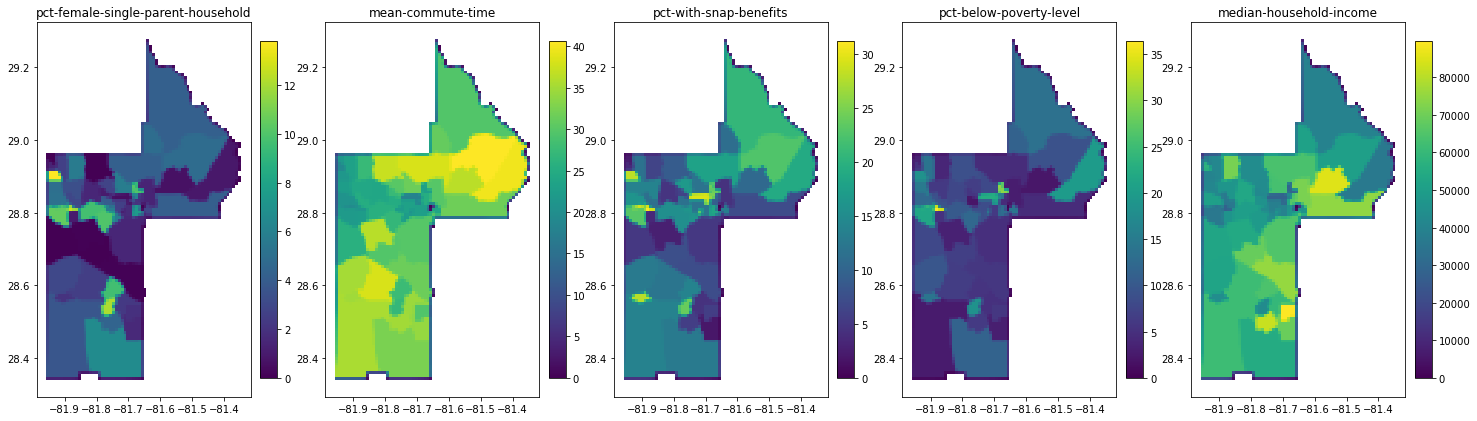

In [27]:
num_vars = len(lake_FEAT_vars)
width = 5 * num_vars
fig, ax = plt.subplots(nrows=1, ncols=num_vars, figsize=(width,8))

for idx, i in enumerate(lake_FEAT_vars):
    ax[idx].set_title(i)
    indicators_by_cell.plot(
        ax=ax[idx],
        column=i,
        legend=True,
        legend_kwds={'fraction': 0.07, 'pad': 0.04}
    )

<AxesSubplot:title={'center':'Reaggregated into cells'}>

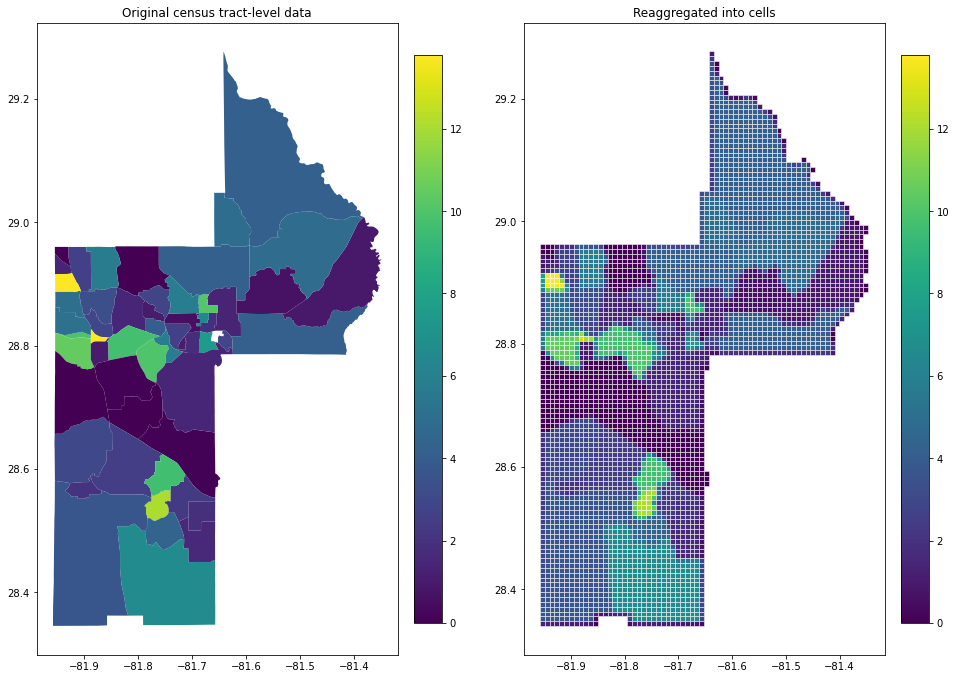

In [28]:
# Was it reaggregated correctly? Compare original data to reaggregated data 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,12))

# Original
ax[0].set_title("Original census tract-level data")
lake_tract_indicators.plot(
    ax=ax[0],
    column=lake_FEAT_vars[0],
    legend=True,
    legend_kwds={'fraction': 0.07, 'pad': 0.04}
)

# Reaggregated
ax[1].set_title("Reaggregated into cells")
indicators_by_cell.plot(
    ax=ax[1],
    column=lake_FEAT_vars[0],
    edgecolor='white',
    linewidth=0.5,
    legend=True,
    legend_kwds={'fraction': 0.07, 'pad': 0.04}
)

# Looks good, but note significant edge distortions. 

### 4.2 Normalize cell-level indicators to 0-1 and create cell-level index score

Option 1:
- Calculate z-score for each indicator (i.e. number of standard deviations away from mean)
- Adjust sign of z-score if necessary (invert if the indicator has negative correlation with eviction filing rate)
- Combine individual z-scores by taking the mean
- Use mean as the cell's composite index score for ranking

In [29]:
for i in lake_FEAT_vars:
    var_name = i + "_zscore"
    indicators_by_cell[var_name] = standardize(indicators_by_cell[i])

indicators_by_cell.head()

,cell_id,geometry,pct-female-single-parent-household,mean-commute-time,pct-with-snap-benefits,pct-below-poverty-level,median-household-income,pct-female-single-parent-household_zscore,mean-commute-time_zscore,pct-with-snap-benefits_zscore,pct-below-poverty-level_zscore,median-household-income_zscore
0,40,"POLYGON ((-81.95764 28.96279, -81.94866 28.962...",0.000000,8.688959,0.920950,1.321362,14854.116428,-1.375754,-3.081445,-1.870720,-1.380674,-2.498906
1,41,"POLYGON ((-81.95764 28.95493, -81.94866 28.954...",0.044398,13.144954,1.446718,2.078621,23272.467672,-1.357701,-2.460145,-1.786739,-1.229001,-1.947617
2,42,"POLYGON ((-81.95764 28.94707, -81.94866 28.947...",0.744698,11.787975,2.146339,3.128097,33581.443117,-1.072953,-2.649349,-1.674989,-1.018799,-1.272519
3,43,"POLYGON ((-81.95764 28.93921, -81.94866 28.939...",0.844888,11.466333,2.232918,3.258853,34838.341516,-1.032215,-2.694195,-1.661160,-0.992610,-1.190209
4,44,"POLYGON ((-81.95764 28.93135, -81.94866 28.931...",0.830395,11.269644,2.194615,3.202952,34240.738076,-1.038107,-2.721620,-1.667278,-1.003806,-1.229344


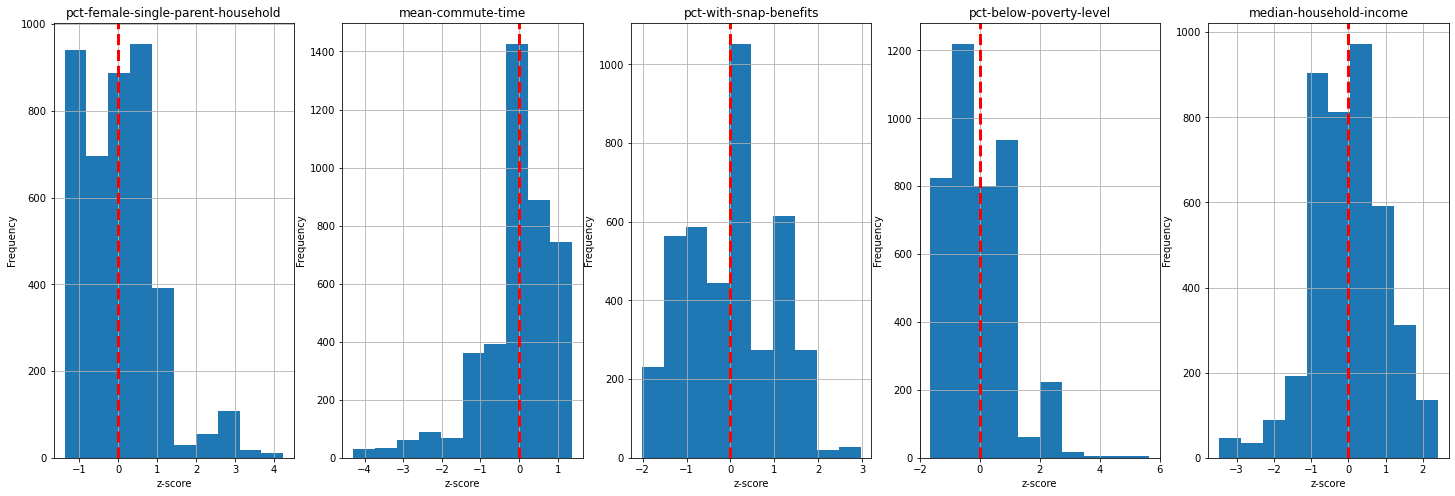

In [30]:
# What is the distribution of z-scores for each indicator?
num_vars = len(lake_FEAT_vars)
width = 5 * num_vars
fig, ax = plt.subplots(nrows=1, ncols=num_vars, figsize=(width,8))

for idx, i in enumerate(lake_FEAT_vars):
    var_name = i + "_zscore"
    indicators_by_cell[var_name].plot(
        ax=ax[idx],
        kind="hist",
        title=i,
        grid=True
    )   
    
    # Other helper info
    ax[idx].axvline(0, color='r', linestyle='--', linewidth=3)
    ax[idx].set(xlabel="z-score")

In [31]:
lake_FEAT_vars

['pct-female-single-parent-household',
 'mean-commute-time',
 'pct-with-snap-benefits',
 'pct-below-poverty-level',
 'median-household-income']

<AxesSubplot:>

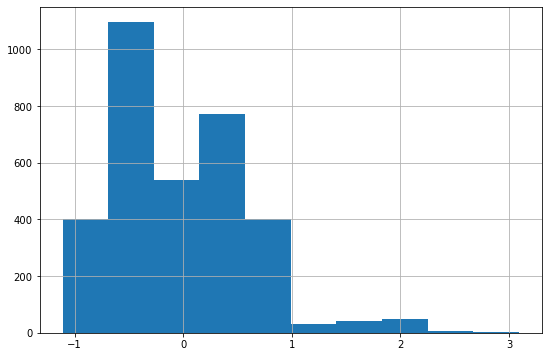

In [32]:
# Sample set of variables to start us off
pos_corr_vars = ["pct-female-single-parent-household", "pct-with-snap-benefits", "pct-below-poverty-level"]
neg_corr_vars = ["mean-commute-time", "median-household-income"]

event_score_df = lake_grid.copy(deep=True)
event_score_df['event_score'] = generate_index_score(indicators_by_cell, pos_corr_vars, neg_corr_vars)
event_score_df['event_score'].hist(figsize=(9,6), grid=True)

In [33]:
# Merge scores onto selected cells
lake_grid_in_buffer_with_index = lake_grid_in_buffer_with_poi \
    .merge(
        event_score_df.drop(columns='geometry'), 
        how='left',
        on='cell_id',
    )

print(lake_grid_in_buffer_with_index.shape)
lake_grid_in_buffer_with_index.head()

(375, 3)


,cell_id,geometry,event_score
0,41,"POLYGON ((-81.95764 28.95493, -81.94866 28.954...",0.006864
1,42,"POLYGON ((-81.95764 28.94707, -81.94866 28.947...",0.031025
2,43,"POLYGON ((-81.95764 28.93921, -81.94866 28.939...",0.039684
3,44,"POLYGON ((-81.95764 28.93135, -81.94866 28.931...",0.048354
4,46,"POLYGON ((-81.95764 28.91563, -81.94866 28.915...",1.460805


<AxesSubplot:title={'center':'Distribution of cell composite index scores'}, ylabel='Frequency'>

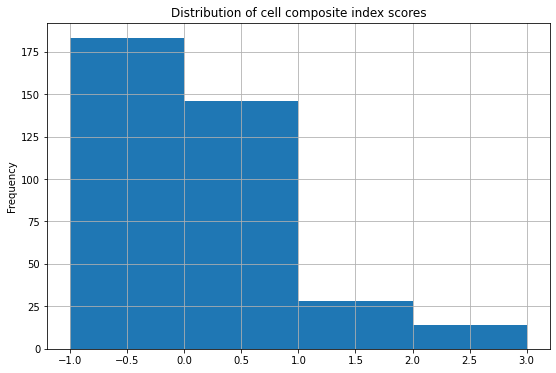

In [34]:
minval = lake_grid_in_buffer_with_index['event_score'].min().round()
maxval = lake_grid_in_buffer_with_index['event_score'].max().round()
bins = list(range(int(minval), int(maxval) + 1))

lake_grid_in_buffer_with_index['event_score'].plot(
    kind='hist', 
    grid=True, 
    title='Distribution of cell composite index scores',
    bins=bins,
    figsize=(9,6),
)

<AxesSubplot:title={'center':'Composite index score of FEAT-derived indicators'}>

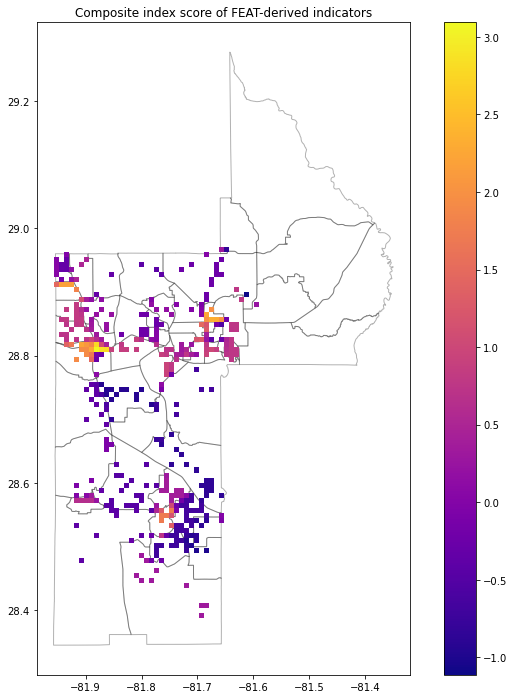

In [35]:
# Plot
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title("Composite index score of FEAT-derived indicators")

# Tract outline
lake_df.plot(ax=ax, color='none', alpha=0.3)

# Index score
lake_grid_in_buffer_with_index.plot(ax=ax, column='event_score', legend=True, cmap='plasma')

## 4.3 Find potential POI in ranked cells

In [36]:
lake_poi_ranked = lake_poi.sjoin(lake_grid_in_buffer_with_index, how='inner') \
    .drop(columns="index_right") \
    .sort_values(by='event_score', ascending=False)

lake_poi_ranked.head(10)

,id,name,type,source,geometry,cell_id,event_score
60978,358740460,First Baptist Church,place_of_worship,openstreetmap,POINT (-81.88472 28.81306),1723,3.092171
80502,593037695,Deaf Service Center of Lake County,nonprofit,IRS 990,POINT (-81.87930 28.80951),1723,3.092171
61094,358743800,Morrison United Methodist Church,place_of_worship,openstreetmap,POINT (-81.88027 28.81088),1723,3.092171
62045,358750345,Central Baptist Church of Leesburg,place_of_worship,openstreetmap,POINT (-81.88166 28.81149),1723,3.092171
65924,844540020,NEXT LEVEL MINISTRIES INC,nonprofit,IRS 990N,POINT (-81.88193 28.80608),1723,3.092171
74572,593585112,Community Medical Care Center of,nonprofit,IRS 990,POINT (-81.88394 28.81126),1723,3.092171
74649,592790823,Christian Care Center Inc,nonprofit,IRS 990,POINT (-81.88523 28.81151),1723,3.092171
75194,593255632,LEESBURG PARTNERSHIP INC,nonprofit,IRS 990,POINT (-81.87712 28.81033),1723,3.092171
79065,591830071,LEESBURG ART FESTIVAL INC,nonprofit,IRS 990,POINT (-81.87724 28.81033),1723,3.092171
60980,358740469,Saint James Episcopal Church,place_of_worship,openstreetmap,POINT (-81.87972 28.81333),1723,3.092171


500

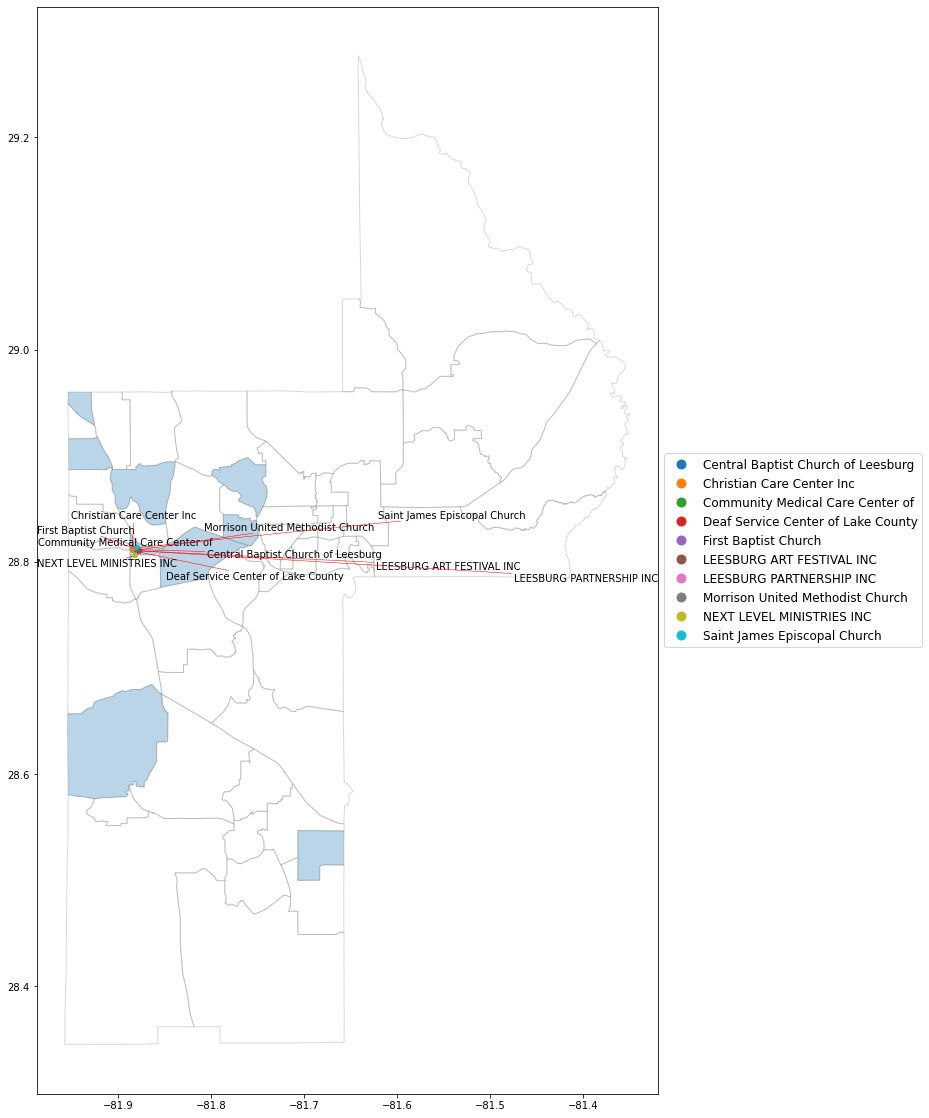

In [42]:
from adjustText import adjust_text

fig, ax = plt.subplots(figsize=(16,20))

# Tract outline
lake_df.plot(ax=ax, facecolor='none', edgecolor='grey', alpha=0.3)

# Tract value highlights
lake_eviction_outliers.plot(ax=ax, alpha=0.3)

# POI in those cells
top_n_to_annotate = 10
lake_poi_ranked.head(top_n_to_annotate) \
    .plot(ax=ax, 
          column='name', 
        markersize=20, 
        legend=True,
        legend_kwds={
            'loc': 'center left',
            'bbox_to_anchor': (1, 0.5),
            'fontsize': 12,
            'markerscale': 1
        }
    )


# Annotate names on chart
poi_site_names = [
    plt.text(
        poi.geometry.x, poi.geometry.y, poi["name"], ha="center", va="center"
    )
    for _, poi in lake_poi_ranked.head(top_n_to_annotate).iterrows()
]
adjust_text(
    poi_site_names, arrowprops={"arrowstyle": "-", "color": "red", "lw": 0.5}
)